In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xscale

In [2]:
fname = '/home/z3526974/Work/data/Shelf_moorings/CH100/IMOS_ANMN-NSW_TZ_20090815_CH100_FV01_TEMP-aggregated-timeseries_END-20190522_C-20190819.nc'
nc = xr.open_dataset(fname)
nc

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 631, OBSERVATION: 13241129)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S256 ...
Attributes:
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Aggregated Time-series Product: This file ...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Klein, Eduardo
    author_email:                  eduardo.kleinsalas@utas.edu.au
    citation:                      The citation in a list of references is: "...
    data_centre:                   Australian Ocean Data Network (AODN)
    data_centre_email:             info@aodn.org.au
    date_created:                  2019-08-19T04:46:11Z
    disclaimer:                    Data, products and services from IMOS are ...
    featureType:                   timeSeries
    file_version:                  Level 1 - Quality Controlled Data
    file_version_quality_control:  Quality controlled data have been through ...
    geospatial_lat_max:            -30.258116
    geospatial_lat_min:            -30.267183
    geospatial_lon_max:            153.39688
    geospatial_lon_min:            153.39255
    geospatial_vertical_max:       100.91409301757812
    geospatial_vertical_min:       -34.80847930908203
    history:                       2019-08-19T04:46:11Z: Aggregated file crea...
    institution_references:        http://imos.org.au/facilities/aodn/
    keywords:                      TEMP, TEMP_quality_control, TIME, DEPTH, D...
    keywords_vocabulary:           IMOS parameter names. See https://github.c...
    license:                       http://creativecommons.org/licenses/by/4.0/
    lineage:                       The variable of interest (VoI) is produced...
    local_time_zone:               
    naming_authority:              IMOS
    project:                       Integrated Marine Observing System (IMOS)
    references:                    http://www.imos.org.au
    rejected_files:                
    site_code:                     CH100
    source:                        Mooring
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2019-05-22T00:25:00Z
    time_coverage_start:           2009-08-15T01:35:04Z
    title:                         Long Timeseries Aggregated product: TEMP a...

## Read in chosen variables to pandas dataframe

In [3]:
df = pd.DataFrame({'TIME': nc.TIME, 'TEMP': nc.TEMP, 'TEMPqc': nc.TEMP_quality_control, 'DEPTH' : nc.DEPTH}).set_index('TIME')
df.head(5)

,TEMP,TEMPqc,DEPTH
TIME,,,
2009-08-15 01:35:04.499997952,15.722848,1.0,99.666359
2009-08-15 01:40:04.499990016,15.543955,1.0,99.726295
2009-08-15 01:45:04.500002304,15.448865,1.0,99.739426
2009-08-15 01:50:04.499994624,15.431899,1.0,99.772530
2009-08-15 01:55:04.499996928,15.427923,1.0,99.790230


## Apply quality control flags

In [4]:
df.TEMPqc.value_counts()

1.0    13240982
4.0         147
Name: TEMPqc, dtype: int64

In [5]:
df_good = df[df.TEMPqc == 1]
df_good.TEMPqc.value_counts()

1.0    13240982
Name: TEMPqc, dtype: int64

## Now use groupby to get particular depths

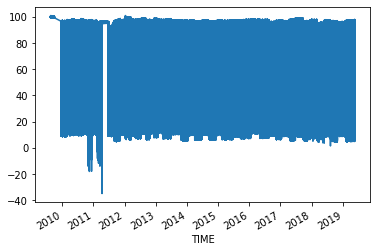

In [6]:
df_good.DEPTH.plot()

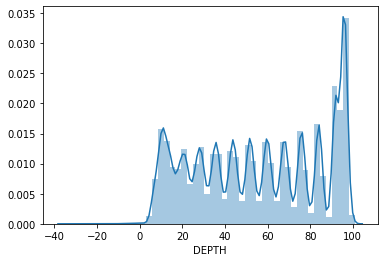

In [7]:
#get distribution of depths
sns.distplot(df_good['DEPTH'].dropna())

In [8]:
binned = pd.cut(x=df_good.DEPTH, bins=[-np.inf, 24, 60,80, np.inf], right=False, labels=['surface', '30-60', '60-80' , 'bottom'])
grouped = df_good.groupby(binned)
surface_temp_1D = grouped.get_group('surface').TEMP.resample('1D').mean()
bottom_temp_1D = grouped.get_group('bottom').TEMP.resample('1D').mean()

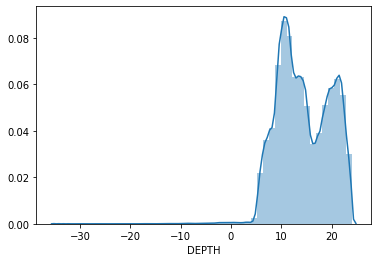

In [9]:
sns.distplot(grouped.get_group('surface').DEPTH)

In [10]:
# Compute the centered 7-day rolling mean
surface_temp_7D = surface_temp_1D.rolling(7, center=True,min_periods=1).mean()
bottom_temp_7D = bottom_temp_1D.rolling(7, center=True,min_periods=1).mean()

#Compute the centered 365-day rolling mean
# Compute the centered 7-day rolling mean
surface_temp_1Y = surface_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()
bottom_temp_1Y = bottom_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()

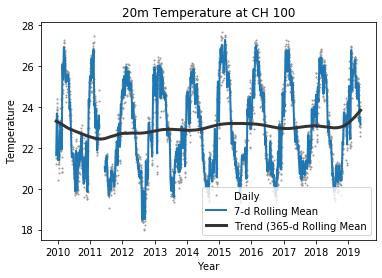

In [11]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(surface_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(surface_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(surface_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('20m Temperature at CH 100');
#plt.savefig('CH100_20m_temperature_tseries.png', dpi=300,bbox_inches='tight')

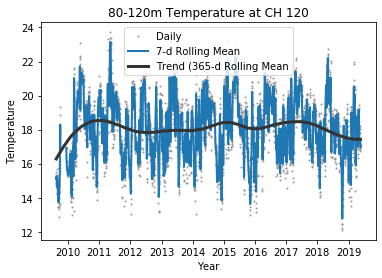

In [12]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(bottom_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(bottom_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(bottom_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-120m Temperature at CH 120');
#plt.savefig('CH100_80-120m_temperature_tseries.png', dpi=300,bbox_inches='tight')

## OK, so this is cute, but to keep things consistent with the SST analysis, and for gapfilling lets rather convert to an Xarray dataset and proceed from there.

In [13]:
DA_surfacetemp = surface_temp_1D.to_xarray()
ds = DA_surfacetemp.to_dataset()
ds = ds.rename({'TIME': 'time'})
ds

<xarray.Dataset>
Dimensions:  (time: 3446)
Coordinates:
  * time     (time) datetime64[ns] 2009-12-15 2009-12-16 ... 2019-05-22
Data variables:
    TEMP     (time) float32 21.230728 22.06511 21.499186 ... 23.400337 23.864344

## Remove seasonal cycle


In [14]:
def xarray_trend(xarr):
    """
    Calculates the trend of the data along the 'time' dimension
    of the input array (xarr).
    USAGE:  x_DS = xarray_trend(xarr)
    INPUT:  xarr is an xarray DataArray with dims:
                time, [lat, lon]
                where lat and/or lon are optional
    OUTPUT: xArray Dataset with:
                original xarr input
                slope
                p-value
    TODO?
    There could be speed improvements (using numpy at the moment)
    """

    from scipy import stats
    # getting shapes

    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    # intercept = ym - (slope * xm)
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr.to_dataset(name=xarr.name)
    # first create variable for slope and adjust meta
    out['slope'] = xarr[:2].mean('time').copy()
    out['slope'].name += '_slope'
    out['slope'].attrs['units'] = 'units / day'
    out['slope'].values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    out['pval'] = xarr[:2].mean('time').copy()
    out['pval'].name += '_Pvalue'
    out['pval'].values = p.reshape(xarr.shape[1:])
    out['pval'].attrs['info'] = ("If p < 0.05 then the results "
                                 "from 'slope' are significant.")

    return out

<xarray.Dataset>
Dimensions:  (time: 2583)
Coordinates:
  * time     (time) datetime64[ns] 2010-02-20 2010-02-21 ... 2017-03-17
Data variables:
    TEMP     (time) float32 24.421831 25.941206 ... 26.049992 25.846891
    slope    float64 0.0001912
    pval     float64 0.0003247

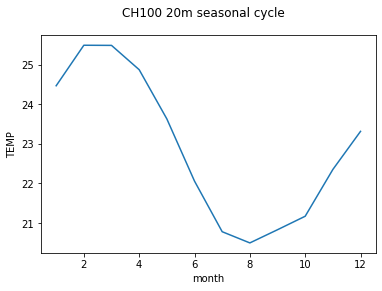

In [16]:
climatology = ds.TEMP.groupby('time.month').mean('time')
anomalies = ds.TEMP.groupby('time.month') - climatology
climatology.plot()
plt.suptitle("CH100 20m seasonal cycle")
plt.savefig('CH100_20m_seasonal_cycle.png', dpi=300,bbox_inches='tight')
#get linear trend
trend = xarray_trend(ds.TEMP.sel(time=slice('2010-02-20', '2017-03-17')))
trend

In [17]:
decade_trend = trend.slope*3650
decade_trend

<xarray.DataArray 'slope' ()>
array(0.6980498)

/home/z3526974/anaconda2/envs/py36/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


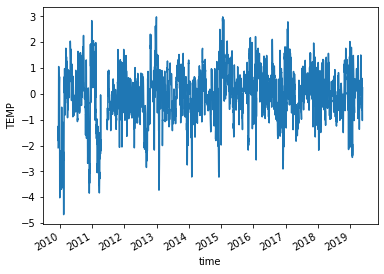

In [18]:
CH_100_anomalies = anomalies
CH_100_anomalies.plot()
#CH_100_anomalies.to_netcdf('CH_100_anomalies_15_24m_processed.nc')
ds.TEMP.to_netcdf('CH_100_15_24m.nc')

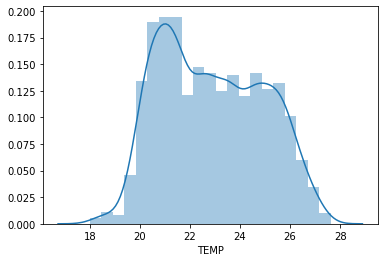

In [17]:
y = surface_temp_1D.fillna(surface_temp_1D.ffill())
sns.distplot(y)